### SetUp

In [2]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns

In [3]:
def normalize_string_columns(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Convert strings in specified columns to lowercase and replace spaces with underscores.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        columns (list[str]): Columns to normalize
        
    Returns:
        pd.DataFrame: DataFrame with transformed string columns
    """
    df_copy = df.copy()
    for col in columns:
        if col in df_copy.columns:
            df_copy[col] = (
                df_copy[col]
                .astype(str)                # Ensure string type
                .str.strip()                # Remove leading/trailing spaces
                .str.lower()                # Lowercase
                .str.replace(r"\s+", "_", regex=True)  # Replace spaces with "_"
            )
    return df_copy

In [4]:
import pandas as pd

def convert_dates_to_days_from_global_max(df: pd.DataFrame, date_columns: list[str]) -> pd.DataFrame:
    """
    Convert given date columns to 'days from global max date'.
    The max date across all columns becomes 0, earlier dates become positive.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        date_columns (list[str]): Columns containing dates
    
    Returns:
        pd.DataFrame, pd.Timestamp: 
            Transformed DataFrame and the global max date
    """
    df_copy = df.copy()

    # Ensure datetime
    for col in date_columns:
        df_copy[col] = pd.to_datetime(df_copy[col])
    
    # Global max date across selected columns
    global_max = df_copy[date_columns].max().max()
    
    # Transform each column
    for col in date_columns:
        df_copy[col] = (global_max - df_copy[col]).dt.days
    
    return df_copy, global_max


In [5]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")


def custom_reports(model, X, y):
    y_pred = model.predict(X)                # Discrete predictions (0/1)
    y_proba = model.predict_proba(X)[:, 1]   # Probabilities for class 1

    # Standard metrics
    accuracy = accuracy_score(y, y_pred)
    auroc = roc_auc_score(y, y_proba)
    precision_value = precision_score(y, y_pred)
    recall_value = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # Display text reports
    print('* Classification Report:')
    print(classification_report(y, y_pred))
    print('* Confusion Matrix:')
    print(confusion_matrix(y, y_pred))

    # Collect metrics in a dictionary
    metrics = {
        "Accuracy": accuracy,
        "ROC AUC": auroc,
        "Precision": precision_value,
        "Recall": recall_value,
        "F1 Score": f1,
    }

    # Convert to DataFrame for nice display
    metrics_df = pd.DataFrame(metrics, index=["Score"]).T
    print("\n* Metrics Table:")
    print(metrics_df)

    return metrics_df

In [6]:
project_path = Path(Path.cwd()).parent.parent
project_path

WindowsPath('c:/Users/jrafa/Desktop/12-sistemas-inteligentes/curso-si-puj')

In [9]:
cancer_detection_path = project_path / "data/inputs/Lung Cancer Dataset.csv"
survival_prediction_path = project_path / "data/inputs/Lung Cancer.csv"

### Cancer Detection Exploration

In [11]:
df_detection = pd.read_csv(cancer_detection_path)

In [12]:
df_detection.shape

(5000, 18)

In [13]:
df_detection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AGE                     5000 non-null   int64  
 1   GENDER                  5000 non-null   int64  
 2   SMOKING                 5000 non-null   int64  
 3   FINGER_DISCOLORATION    5000 non-null   int64  
 4   MENTAL_STRESS           5000 non-null   int64  
 5   EXPOSURE_TO_POLLUTION   5000 non-null   int64  
 6   LONG_TERM_ILLNESS       5000 non-null   int64  
 7   ENERGY_LEVEL            5000 non-null   float64
 8   IMMUNE_WEAKNESS         5000 non-null   int64  
 9   BREATHING_ISSUE         5000 non-null   int64  
 10  ALCOHOL_CONSUMPTION     5000 non-null   int64  
 11  THROAT_DISCOMFORT       5000 non-null   int64  
 12  OXYGEN_SATURATION       5000 non-null   float64
 13  CHEST_TIGHTNESS         5000 non-null   int64  
 14  FAMILY_HISTORY          5000 non-null   

In [14]:
df_detection.head(10)

,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE,PULMONARY_DISEASE
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,NO
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,YES
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,NO
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,YES
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,YES
5,37,1,1,1,1,1,1,57.684285,0,1,1,1,94.057151,1,0,0,0,YES
6,50,0,1,1,1,0,1,52.647022,1,1,1,0,96.773598,0,0,0,1,NO
7,68,0,1,1,1,0,1,53.306451,0,0,0,1,95.019018,0,0,0,0,NO
8,48,0,1,1,0,1,1,64.272789,1,1,0,1,98.539379,1,0,0,0,YES
9,52,0,0,0,1,1,1,58.319319,0,1,0,1,96.055097,0,0,0,0,NO


In [15]:
label_map_dict = {
    'NO': 0,
    'YES': 1
}

df_detection['PULMONARY_DISEASE'] = df_detection['PULMONARY_DISEASE'].map(label_map_dict)

In [16]:
binary_columns = [
    'GENDER',
    'SMOKING',
    'FINGER_DISCOLORATION',
    'MENTAL_STRESS',
    'EXPOSURE_TO_POLLUTION',
    'LONG_TERM_ILLNESS',
    'IMMUNE_WEAKNESS',
    'BREATHING_ISSUE',
    'ALCOHOL_CONSUMPTION',
    'THROAT_DISCOMFORT',
    'CHEST_TIGHTNESS',
    'FAMILY_HISTORY',
    'SMOKING_FAMILY_HISTORY',
    'STRESS_IMMUNE',
    'PULMONARY_DISEASE'
]

df_detection[binary_columns] = df_detection[binary_columns].astype('category')

In [17]:
df_detection_numerical = df_detection.select_dtypes(exclude=['category'])

In [18]:
corr_matrix = df_detection_numerical.corr()
print(corr_matrix)

                        AGE  ENERGY_LEVEL  OXYGEN_SATURATION
AGE                1.000000     -0.006921          -0.001354
ENERGY_LEVEL      -0.006921      1.000000           0.008761
OXYGEN_SATURATION -0.001354      0.008761           1.000000


Correlación bastante baja entre todas las variables numéricas

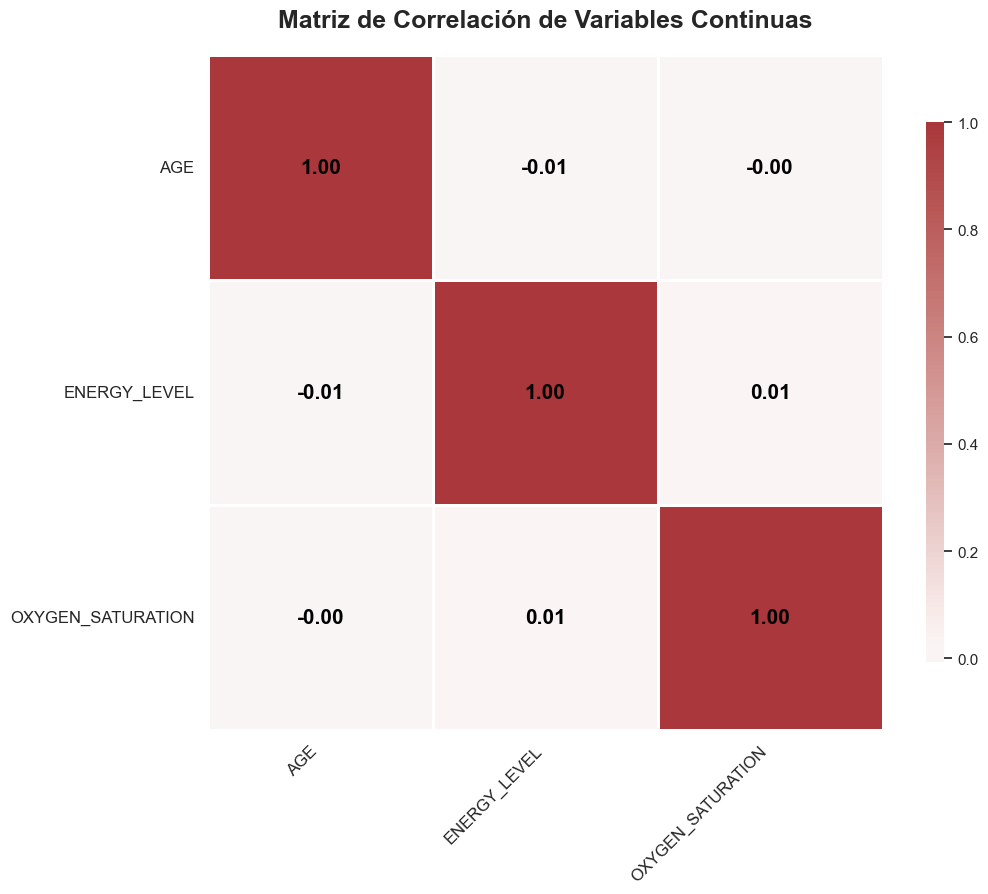

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = df_detection_numerical.corr()

# Use a clean aesthetic style
sns.set_theme(style="whitegrid")

# Create figure
plt.figure(figsize=(11, 9))

# Better color map for correlation visualization
# "coolwarm" clearly separates positive/negative; "RdBu_r" is another classy option
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="vlag",        # try also: "RdYlBu_r", "vlag", or "ch:s=-.2,r=.6"
    center=0,
    square=True,
    linewidths=0.8,
    annot_kws={"size": 15, "color": "black", "weight": "bold"},
    cbar_kws={"shrink": 0.8, "aspect": 30}
)

# Titles and axis formatting
plt.title("Matriz de Correlación de Variables Continuas", fontsize=18, weight="bold", pad=20)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


In [19]:
df_detection_binary = df_detection.select_dtypes(include=['category'])

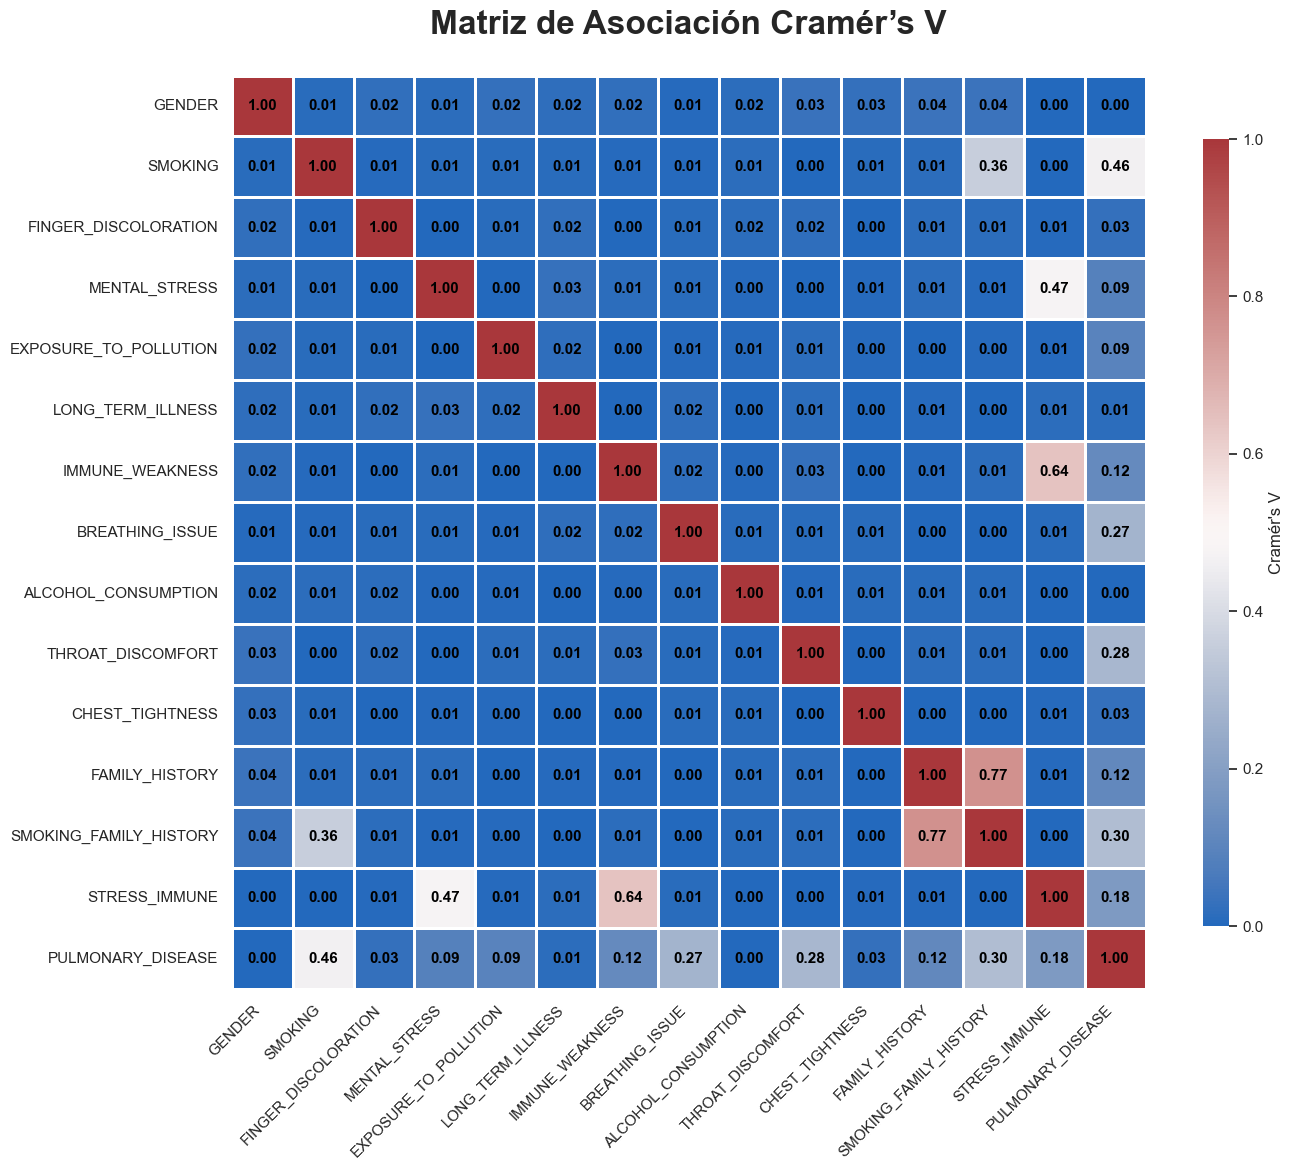

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Compute Cramer's V for two categorical (binary) variables."""
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Build Cramer's V correlation matrix
cols = df_detection_binary.columns
n = len(cols)
cramers_results = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)

for i in range(n):
    for j in range(n):
        if i == j:
            cramers_results.iloc[i, j] = 1.0
        else:
            cramers_results.iloc[i, j] = cramers_v(
                df_detection_binary.iloc[:, i],
                df_detection_binary.iloc[:, j]
            )

# Set aesthetic style
sns.set_theme(style="whitegrid")

# Create larger, elegant heatmap
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(
    cramers_results,
    annot=True,
    fmt=".2f",
    cmap="vlag",             # Soft, professional color palette
    vmin=0, vmax=1,
    square=True,
    linewidths=0.8,
    annot_kws={"size": 11, "color": "black", "weight": "bold"},
    cbar_kws={"shrink": 0.8, "aspect": 30, "label": "Cramér's V"}
)

# Beautiful title and axis formatting
plt.title(
    "Matriz de Asociación Cramér’s V",
    fontsize=24,
    weight="bold",
    pad=30
)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_continuous_by_binary(df, continuous_col, binary_x="SMOKING", binary_hue="PULMONARY_DISEASE"):
    """
    Plots a boxplot showing how a continuous variable varies
    according to two binary categorical variables.
    
    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    continuous_col : str
        Name of the continuous (numeric) column to plot on Y-axis.
    binary_x : str, default="SMOKING"
        Binary feature to use on the X-axis.
    binary_hue : str, default="PULMONARY_DISEASE"
        Binary feature to use as color (hue).
    """
    
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(10, 7))
    
    sns.boxplot(
        data=df,
        x=binary_x,
        y=continuous_col,
        hue=binary_hue,
        palette="coolwarm",
        width=0.6,
        fliersize=3
    )

    title = f"{continuous_col.replace('_', ' ').title()} by {binary_x.replace('_', ' ').title()} and {binary_hue.replace('_', ' ').title()}"
    plt.title(title, fontsize=22, weight="bold", pad=25)
    plt.xlabel(f"{binary_x} (0 = No, 1 = Yes)", fontsize=13, labelpad=10)
    plt.ylabel(continuous_col.replace('_', ' ').title(), fontsize=13, labelpad=10)

    plt.legend(
        title=binary_hue.replace('_', ' ').title(),
        title_fontsize=12,
        fontsize=11,
        loc="upper right",
        frameon=True
    )

    plt.tight_layout()
    plt.show()


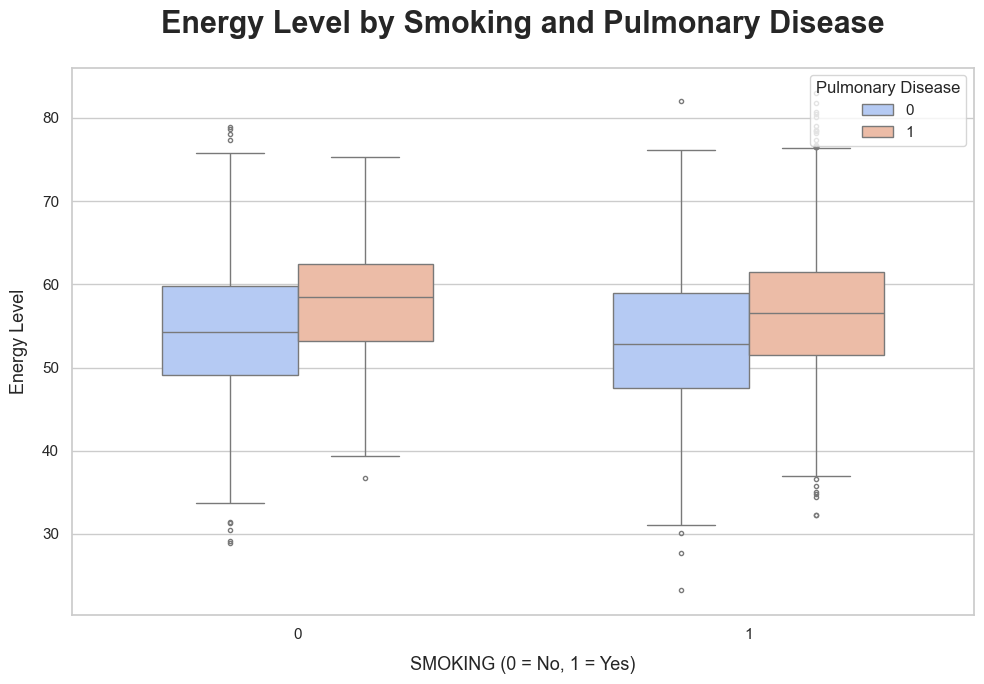

In [22]:
plot_continuous_by_binary(df_detection, continuous_col="ENERGY_LEVEL")

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_box_by_target(df, continuous_col, target_col="PULMONARY_DISEASE"):
    """
    Draws a simple boxplot showing how a continuous variable 
    varies according to a binary target.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    continuous_col : str
        Continuous feature for the Y-axis.
    target_col : str, default="PULMONARY_DISEASE"
        Binary target for the X-axis.
    """

    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(8, 6))
    
    sns.boxplot(
        data=df,
        x=target_col,
        y=continuous_col,
        palette="coolwarm",
        width=0.6,
        fliersize=3
    )

    # Titles and labels
    title = f"{continuous_col.replace('_', ' ').title()} by {target_col.replace('_', ' ').title()}"
    plt.title(title, fontsize=22, weight="bold", pad=25)
    plt.xlabel(target_col.replace('_', ' ').title(), fontsize=13, labelpad=10)
    plt.ylabel(continuous_col.replace('_', ' ').title(), fontsize=13, labelpad=10)

    plt.tight_layout()
    plt.show()


C:\Users\jrafa\AppData\Local\Temp\ipykernel_44756\2340807017.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


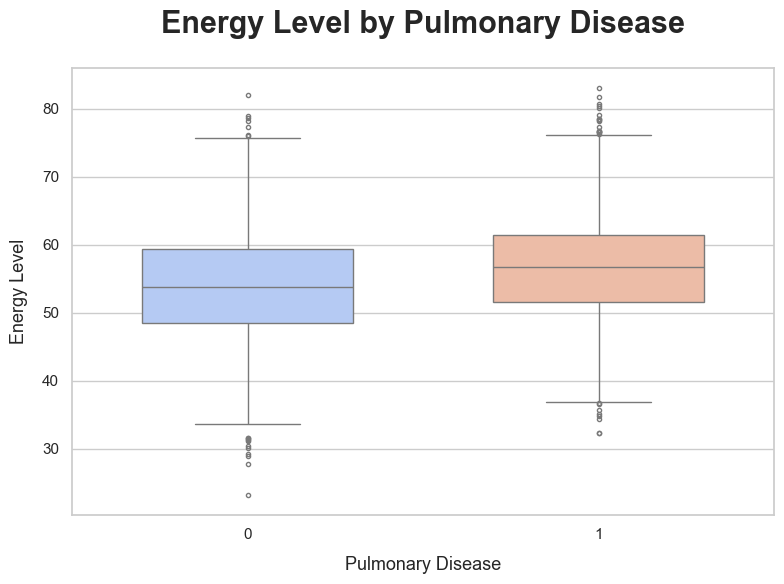

In [24]:
plot_box_by_target(df_detection, continuous_col="ENERGY_LEVEL")

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatter_by_binary(df, continuous_col, binary_x="SMOKING", binary_hue="PULMONARY_DISEASE"):
    """
    Plots a scatter plot showing how a continuous variable varies
    according to two binary categorical variables.
    """

    sns.set_theme(style="white")  # removes grid

    plt.figure(figsize=(8, 6))

    sns.stripplot(
        data=df,
        x=binary_x,
        y=continuous_col,
        hue=binary_hue,
        dodge=True,
        palette="coolwarm",
        size=6,
        alpha=0.8
    )

    # Labels (no title)
    plt.xlabel(f"{binary_x.replace('_', ' ').title()} (0 = No, 1 = Yes)", fontsize=12)
    plt.ylabel(continuous_col.replace('_', ' ').title(), fontsize=12)

    # Legend above plot
    plt.legend(
        title=binary_hue.replace('_', ' ').title(),
        bbox_to_anchor=(0.5, 1.15),  # above the plot
        loc="center",
        ncol=2,
        frameon=False,
        fontsize=11
    )

    plt.tight_layout()
    plt.show()


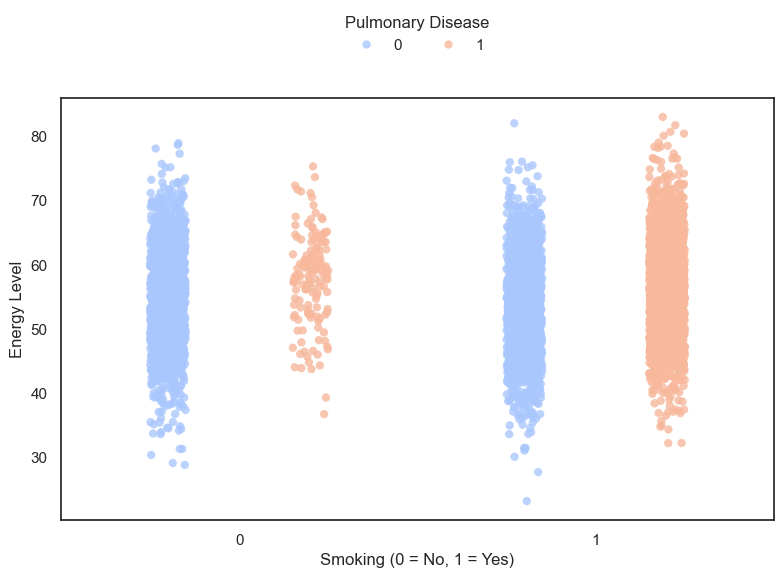

In [29]:
plot_scatter_by_binary(df_detection, continuous_col="ENERGY_LEVEL")


In [17]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

SEED = 1
train_df, test_df = train_test_split(df_detection, test_size=0.2, random_state=SEED)

X_train = train_df.drop(columns=['PULMONARY_DISEASE']).values
y_train = train_df['PULMONARY_DISEASE'].values

X_test = test_df.drop(columns=['PULMONARY_DISEASE']).values
y_test = test_df['PULMONARY_DISEASE'].values

In [18]:
model = LGBMClassifier(random_state=SEED, verbose=-1)
model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [19]:
y_preds = model.predict(X_test)
y_preds[0:10]

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0])

In [20]:
y_preds = model.predict_proba(X_test)
y_preds[0:10, :]

array([[0.88192426, 0.11807574],
       [0.97642674, 0.02357326],
       [0.92489122, 0.07510878],
       [0.83424959, 0.16575041],
       [0.84628519, 0.15371481],
       [0.03292415, 0.96707585],
       [0.06016431, 0.93983569],
       [0.84413412, 0.15586588],
       [0.12524302, 0.87475698],
       [0.92562223, 0.07437777]])

In [21]:
custom_reports(model, X_test, y_test)

* Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       623
           1       0.89      0.87      0.88       377

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

* Confusion Matrix:
[[584  39]
 [ 48 329]]

* Metrics Table:
              Score
Accuracy   0.913000
ROC AUC    0.919496
Precision  0.894022
Recall     0.872679
F1 Score   0.883221


,Score
Accuracy,0.913000
ROC AUC,0.919496
Precision,0.894022
Recall,0.872679
F1 Score,0.883221


### Survival

In [57]:
df_survival = df_survival.drop(columns=['id'])

In [58]:
df_survival.shape

(890000, 16)

In [59]:
df_survival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 890000 non-null  float64
 1   gender              890000 non-null  object 
 2   country             890000 non-null  object 
 3   diagnosis_date      890000 non-null  object 
 4   cancer_stage        890000 non-null  object 
 5   family_history      890000 non-null  object 
 6   smoking_status      890000 non-null  object 
 7   bmi                 890000 non-null  float64
 8   cholesterol_level   890000 non-null  int64  
 9   hypertension        890000 non-null  int64  
 10  asthma              890000 non-null  int64  
 11  cirrhosis           890000 non-null  int64  
 12  other_cancer        890000 non-null  int64  
 13  treatment_type      890000 non-null  object 
 14  end_treatment_date  890000 non-null  object 
 15  survived            890000 non-nul

In [60]:
df_survival.head(10)

,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0
5,50.0,Male,Italy,2023-01-02,Stage I,No,Never Smoked,37.6,274,1,0,0,0,Radiation,2024-12-27,0
6,49.0,Female,Croatia,2018-05-21,Stage III,Yes,Passive Smoker,43.1,259,0,0,0,0,Radiation,2019-05-06,1
7,51.0,Male,Denmark,2017-02-18,Stage IV,Yes,Former Smoker,25.8,195,1,1,0,0,Combined,2017-08-26,0
8,64.0,Male,Sweden,2021-03-21,Stage III,Yes,Current Smoker,21.5,236,0,0,0,0,Chemotherapy,2022-03-07,0
9,56.0,Male,Hungary,2021-11-30,Stage IV,Yes,Current Smoker,17.3,183,1,0,0,1,Surgery,2023-11-29,0


In [61]:
int_col = ['age', 'cholesterol_level']

df_survival[int_col] = df_survival[int_col].astype('int64')

In [62]:
date_cols = ['diagnosis_date', 'end_treatment_date']

df_survival[date_cols] = df_survival[date_cols].apply(pd.to_datetime)

In [63]:
map_dict_familiy_history = {
    'No': 0,
    'Yes': 1
}

map_dict_gender = {
    'Male': 0,
    'Female': 1
}

map_dict_cancer_stage = {
    'Stage I': 1,
    'Stage II': 2,
    'Stage III': 3,
    'Stage IV': 4
}

df_survival['family_history'] = df_survival['family_history'].map(map_dict_familiy_history)
df_survival['gender'] = df_survival['gender'].map(map_dict_gender)
df_survival['cancer_stage'] = df_survival['cancer_stage'].map(map_dict_cancer_stage)

In [64]:
object_cols = df_survival.select_dtypes(include=['object']).columns.tolist()
object_cols

['country', 'smoking_status', 'treatment_type']

In [65]:
df_survival = normalize_string_columns(df_survival, object_cols)

In [66]:
df_survival.head()

,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,64,0,sweden,2016-04-05,1,1,passive_smoker,29.4,199,0,0,1,0,chemotherapy,2017-09-10,0
1,50,1,netherlands,2023-04-20,3,1,passive_smoker,41.2,280,1,1,0,0,surgery,2024-06-17,1
2,65,1,hungary,2023-04-05,3,1,former_smoker,44.0,268,1,1,0,0,combined,2024-04-09,0
3,51,1,belgium,2016-02-05,1,0,passive_smoker,43.0,241,1,1,0,0,chemotherapy,2017-04-23,0
4,37,0,luxembourg,2023-11-29,1,0,passive_smoker,19.7,178,0,0,0,0,combined,2025-01-08,0


In [67]:
category_cols = [
    'gender',
    'country',
    'cancer_stage',
    'family_history',
    'smoking_status',
    'cholesterol_level',
    'hypertension',
    'asthma',
    'cirrhosis',
    'other_cancer',
    'treatment_type',
    'survived'
]

df_survival[category_cols] = df_survival[category_cols].astype('category')

In [68]:
df_survival

,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,64,0,sweden,2016-04-05,1,1,passive_smoker,29.4,199,0,0,1,0,chemotherapy,2017-09-10,0
1,50,1,netherlands,2023-04-20,3,1,passive_smoker,41.2,280,1,1,0,0,surgery,2024-06-17,1
2,65,1,hungary,2023-04-05,3,1,former_smoker,44.0,268,1,1,0,0,combined,2024-04-09,0
3,51,1,belgium,2016-02-05,1,0,passive_smoker,43.0,241,1,1,0,0,chemotherapy,2017-04-23,0
4,37,0,luxembourg,2023-11-29,1,0,passive_smoker,19.7,178,0,0,0,0,combined,2025-01-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889995,40,0,malta,2022-07-01,4,0,passive_smoker,44.8,243,1,1,1,0,radiation,2023-02-23,0
889996,62,1,cyprus,2015-09-27,2,1,former_smoker,21.6,240,0,0,0,0,surgery,2017-06-19,0
889997,48,1,estonia,2016-03-27,3,1,never_smoked,38.6,242,1,0,0,0,combined,2017-01-23,1
889998,67,1,slovakia,2015-12-22,4,1,former_smoker,18.6,194,1,1,0,0,chemotherapy,2017-12-12,0


In [69]:
df_survival, _ = convert_dates_to_days_from_global_max(df_survival, date_cols)

In [70]:
df_survival

,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,64,0,sweden,3707,1,1,passive_smoker,29.4,199,0,0,1,0,chemotherapy,3184,0
1,50,1,netherlands,1136,3,1,passive_smoker,41.2,280,1,1,0,0,surgery,712,1
2,65,1,hungary,1151,3,1,former_smoker,44.0,268,1,1,0,0,combined,781,0
3,51,1,belgium,3767,1,0,passive_smoker,43.0,241,1,1,0,0,chemotherapy,3324,0
4,37,0,luxembourg,913,1,0,passive_smoker,19.7,178,0,0,0,0,combined,507,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889995,40,0,malta,1429,4,0,passive_smoker,44.8,243,1,1,1,0,radiation,1192,0
889996,62,1,cyprus,3898,2,1,former_smoker,21.6,240,0,0,0,0,surgery,3267,0
889997,48,1,estonia,3716,3,1,never_smoked,38.6,242,1,0,0,0,combined,3414,1
889998,67,1,slovakia,3812,4,1,former_smoker,18.6,194,1,1,0,0,chemotherapy,3091,0


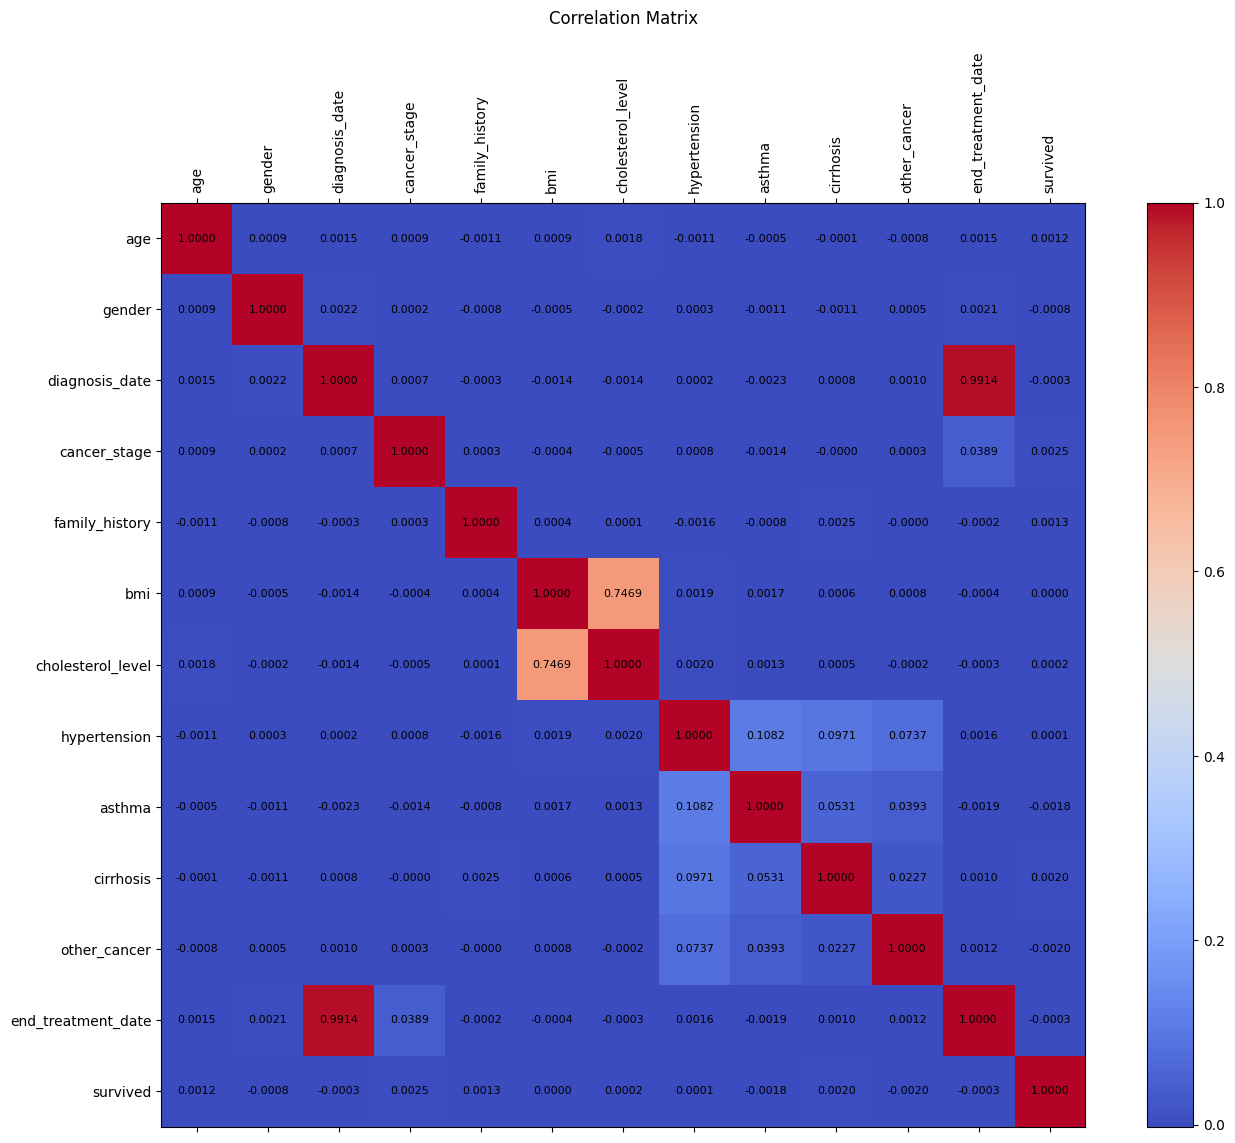

In [71]:
import matplotlib.pyplot as plt

# Compute correlation
corr = df_survival.drop(columns=['country', 'smoking_status', 'treatment_type']).corr()

# Plot with matplotlib
fig, ax = plt.subplots(figsize=(16, 12))
cax = ax.matshow(corr, cmap="coolwarm")

# Add colorbar
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

# Annotate each cell with the correlation value
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.4f}", ha="center", va="center", color="black", fontsize=8)

plt.title("Correlation Matrix", pad=20)
plt.show()


In [72]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

ohe_cols = ['country', 'smoking_status', 'treatment_type']

encoded = encoder.fit_transform(df_survival[ohe_cols])

encoded_df = pd.DataFrame(
    encoded, 
    columns=encoder.get_feature_names_out(ohe_cols),
    index=df_survival.index
)

df_final = pd.concat([df_survival.drop(columns=ohe_cols), encoded_df], axis=1)

In [73]:
df_final

,age,gender,diagnosis_date,cancer_stage,family_history,bmi,cholesterol_level,hypertension,asthma,cirrhosis,...,country_slovakia,country_slovenia,country_spain,country_sweden,smoking_status_former_smoker,smoking_status_never_smoked,smoking_status_passive_smoker,treatment_type_combined,treatment_type_radiation,treatment_type_surgery
0,64,0,3707,1,1,29.4,199,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,50,1,1136,3,1,41.2,280,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,65,1,1151,3,1,44.0,268,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,51,1,3767,1,0,43.0,241,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,37,0,913,1,0,19.7,178,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889995,40,0,1429,4,0,44.8,243,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
889996,62,1,3898,2,1,21.6,240,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
889997,48,1,3716,3,1,38.6,242,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
889998,67,1,3812,4,1,18.6,194,1,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [74]:
encoder.get_feature_names_out(ohe_cols)

array(['country_belgium', 'country_bulgaria', 'country_croatia',
       'country_cyprus', 'country_czech_republic', 'country_denmark',
       'country_estonia', 'country_finland', 'country_france',
       'country_germany', 'country_greece', 'country_hungary',
       'country_ireland', 'country_italy', 'country_latvia',
       'country_lithuania', 'country_luxembourg', 'country_malta',
       'country_netherlands', 'country_poland', 'country_portugal',
       'country_romania', 'country_slovakia', 'country_slovenia',
       'country_spain', 'country_sweden', 'smoking_status_former_smoker',
       'smoking_status_never_smoked', 'smoking_status_passive_smoker',
       'treatment_type_combined', 'treatment_type_radiation',
       'treatment_type_surgery'], dtype=object)

In [77]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

SEED = 1
train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=SEED, stratify=df_final['survived'])

X_train = train_df.drop(columns=['survived']).values
y_train = train_df['survived'].values

X_test = test_df.drop(columns=['survived']).values
y_test = test_df['survived'].values

In [81]:
train_df['survived'].value_counts(normalize=True)

survived
0    0.779771
1    0.220229
Name: proportion, dtype: float64

In [82]:
model = LGBMClassifier(random_state=SEED, verbose=-1)
model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [83]:
custom_reports(model, X_test, y_test)

c:\Users\jrafa\Desktop\9. Universidad\Sistemas Inteligentes\Proyecto\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jrafa\Desktop\9. Universidad\Sistemas Inteligentes\Proyecto\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


* Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    138799
           1       0.00      0.00      0.00     39201

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000

* Confusion Matrix:
[[138799      0]
 [ 39201      0]]

* Metrics Table:
              Score
Accuracy   0.779770
ROC AUC    0.502343
Precision  0.000000
Recall     0.000000
F1 Score   0.000000


c:\Users\jrafa\Desktop\9. Universidad\Sistemas Inteligentes\Proyecto\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jrafa\Desktop\9. Universidad\Sistemas Inteligentes\Proyecto\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Score
Accuracy,0.779770
ROC AUC,0.502343
Precision,0.000000
Recall,0.000000
F1 Score,0.000000
